# Stellar Classification with RandomForest and SVM

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from scipy.stats import uniform
from sklearn.calibration import LinearSVC

import warnings
warnings.filterwarnings('ignore')


## Load and Check Data

    SDSS Astronomical Dataset - Feature Description
This dataset consists of **100,000 astronomical observations** collected by the **Sloan Digital Sky Survey (SDSS)**. Each observation contains **17 features** describing the object and **1 class label** indicating whether the object is a **star**, **galaxy**, or **quasar**.

    📦 Dataset Columns

| Column Name      | Description |
|------------------|-------------|
| `obj_ID`         | Object Identifier — a unique ID for the object in the image catalog used by the CAS |
| `alpha`          | Right Ascension angle (at J2000 epoch) |
| `delta`          | Declination angle (at J2000 epoch) |
| `u`              | Ultraviolet filter magnitude in the photometric system |
| `g`              | Green filter magnitude in the photometric system |
| `r`              | Red filter magnitude in the photometric system |
| `i`              | Near Infrared filter magnitude in the photometric system |
| `z`              | Infrared filter magnitude in the photometric system |
| `run_ID`         | Run Number — identifies the specific scan |
| `rerun_ID`       | Rerun Number — specifies how the image was processed |
| `cam_col`        | Camera column — identifies the scanline within the run |
| `field_ID`       | Field number — identifies each field |
| `spec_obj_ID`    | Spectroscopic Object ID — unique for optical spectroscopic observations<br>**Note:** Two different observations with the same `spec_obj_ID` must have the same class label |
| `class`          | Object class — one of: `GALAXY`, `STAR`, `QSO` (quasar) |
| `redshift`       | Redshift value — indicates the increase in wavelength |
| `plate`          | Plate ID — identifies each plate in the SDSS |
| `MJD`            | Modified Julian Date — indicates the date the data was taken |
| `fiber_ID`       | Fiber ID — identifies the fiber that pointed the light at the focal plane |



### Loading data

In [5]:
file_path = 'Data\\star_classification.csv'
Stars_df = pd.read_csv(filepath_or_buffer=file_path)
Stars_df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


### Data cheking

In [6]:
Stars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [7]:
Stars_df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


### Distribution of class feature

In [8]:
a, b, c = Stars_df["class"].value_counts() / len(Stars_df)
print(f"Total percentage of Galaxies : {round(a*100, 1)}%")
print(f"Total percentage of Stars : {round(b*100, 1)}%")
print(f"Total percentage of QSO : {round(c*100, 1)}%")

Total percentage of Galaxies : 59.4%
Total percentage of Stars : 21.6%
Total percentage of QSO : 19.0%


<Axes: xlabel='class', ylabel='count'>

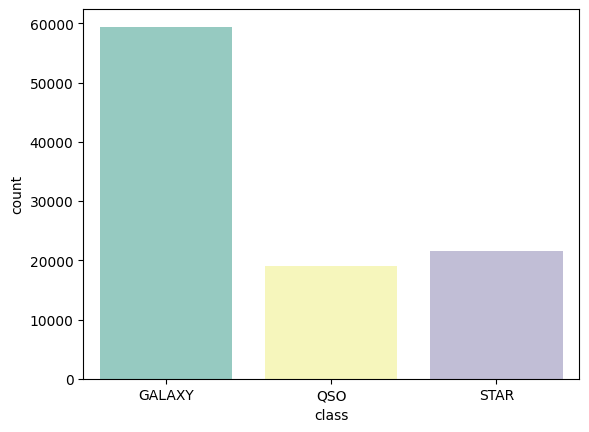

In [9]:
sns.countplot(x = Stars_df["class"], palette="Set3")

#### Class Imbalance Notice

We observe that the classes are **not evenly distributed**.  
Therefore, in the train/test split step, we need to use **stratification** to preserve the class proportions.

### Feature Selection Update

In the following steps, we will **exclude all non-astronomical features** and continue modeling using **only astronomical data**.

In [10]:
Stars_df = Stars_df[['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'plate', 'MJD', 'class']]

# Visualization of Data

### Visualization of alpha, delta, redshift, plate and MJD

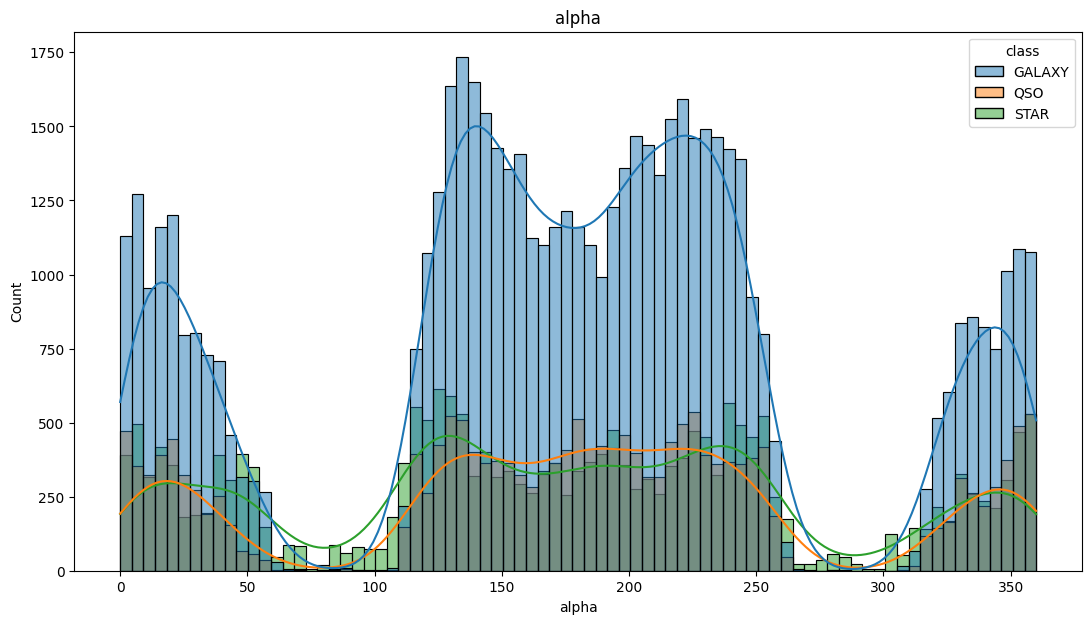

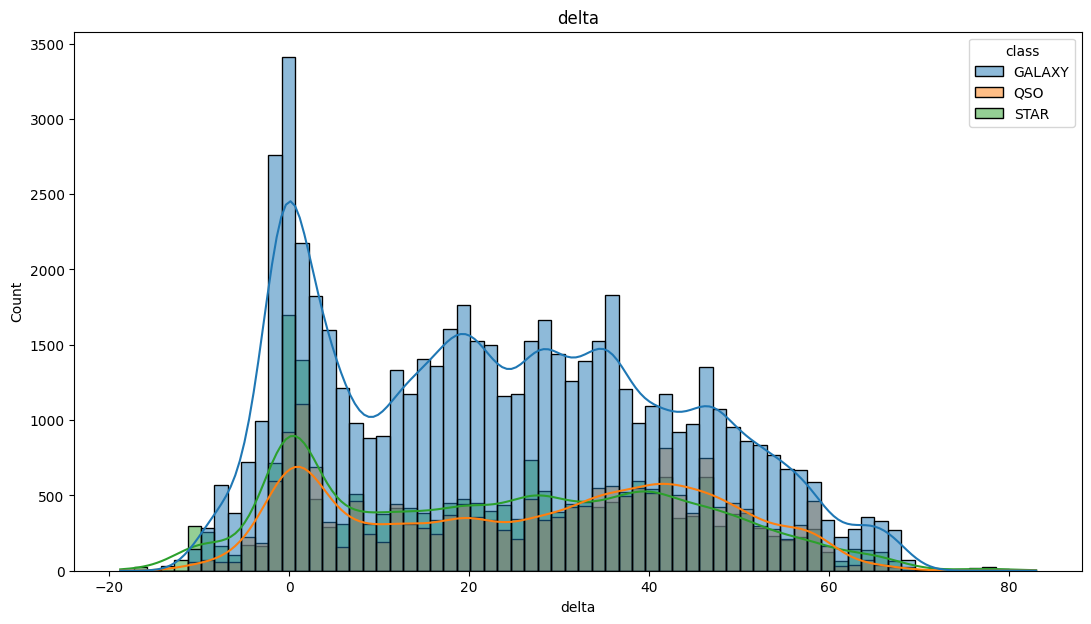

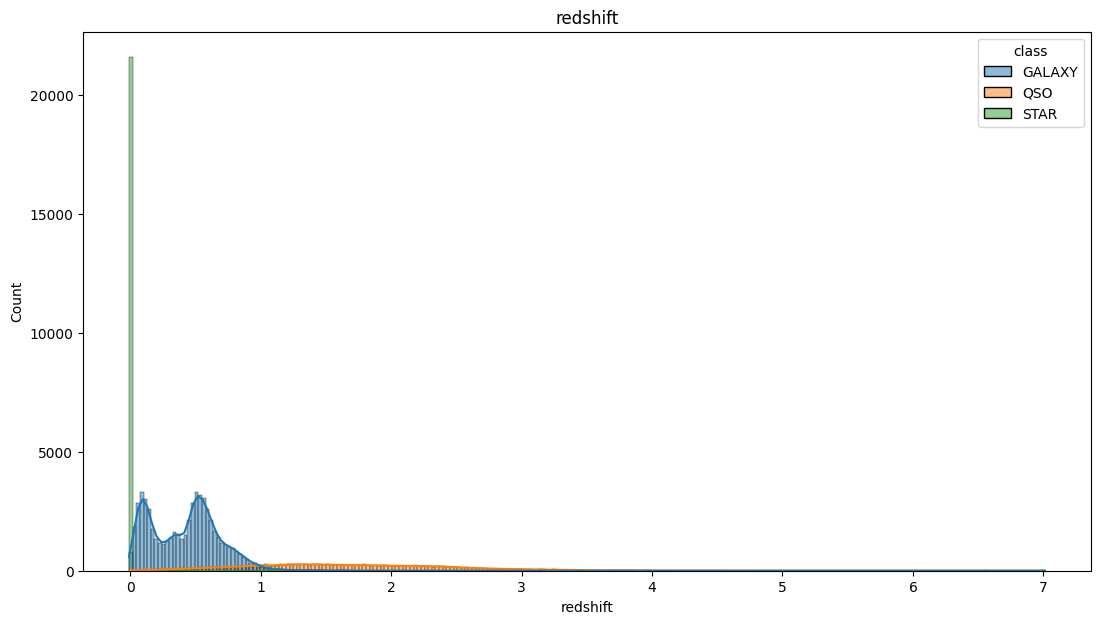

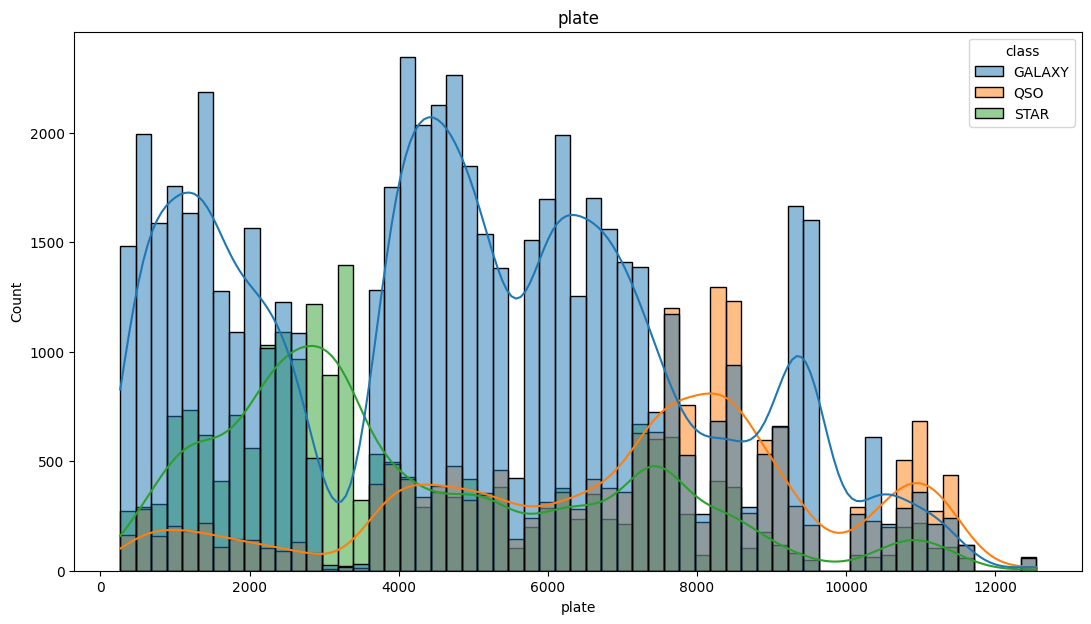

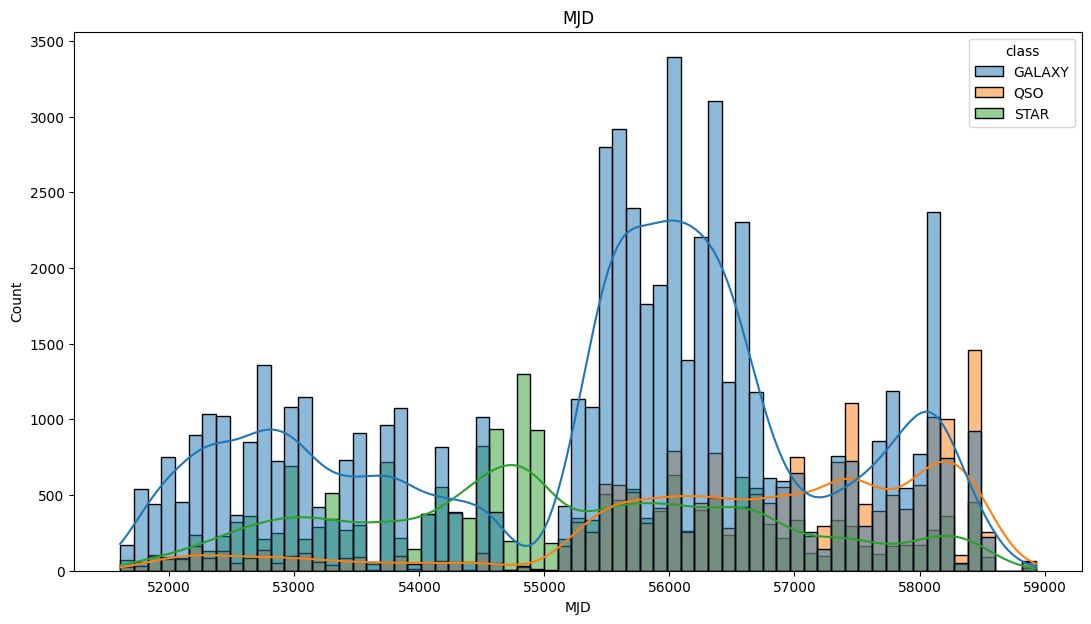

In [11]:
for i in ['alpha', 'delta','redshift', 'plate', 'MJD']:
    plt.figure(figsize=(13,7))
    sns.histplot(data=Stars_df, x=i, kde=True, hue="class")
    plt.title(i)
    plt.show()

### Visualization of photometrics filters

In [12]:
# use of KDE to visualise the photometric filters u, g, r, i and z

from sklearn.calibration import LabelEncoder


le = LabelEncoder()
Stars_df["class"] = le.fit_transform(Stars_df["class"])
Stars_df["class"] = Stars_df["class"].astype(int)

def plot(column):
    for i in range(3):
        sns.kdeplot(data=Stars_df[Stars_df["class"] == i][column], label = le.inverse_transform([i]), fill = True)
    sns.kdeplot(data=Stars_df[column],label = ["All"], fill = True)
    plt.legend()
    
def log_plot(column):
    for i in range(3):
        sns.kdeplot(data=np.log(Stars_df[Stars_df["class"] == i][column]), label = le.inverse_transform([i]), fill = True)
    sns.kdeplot(data=np.log(Stars_df[column]),label = ["All"], fill = True)
    plt.legend() 

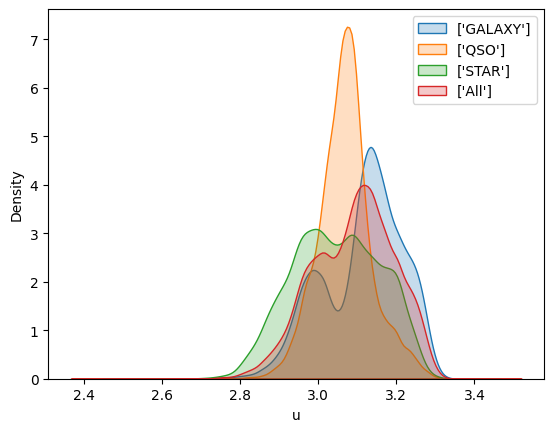

In [13]:
#log due to extreme values
log_plot('u')

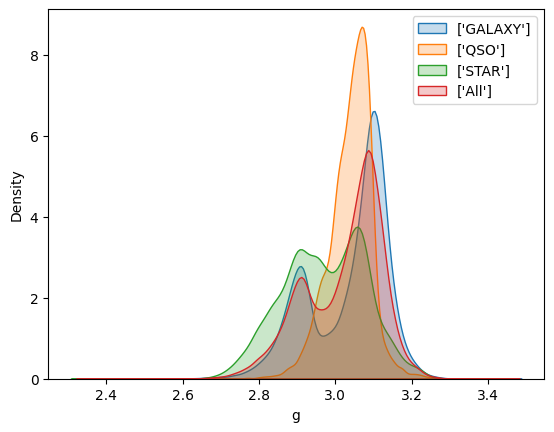

In [14]:
#log due to extreme values
log_plot('g')

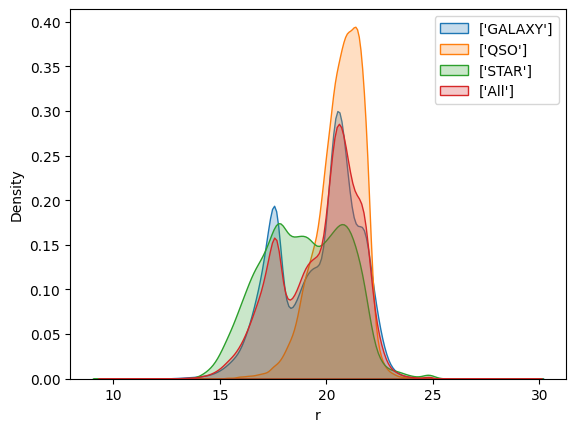

In [15]:
plot('r')

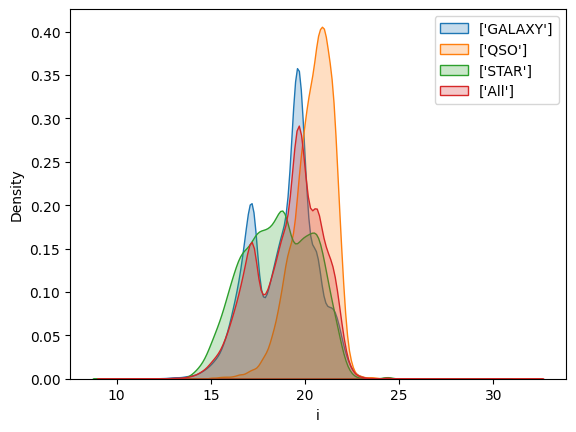

In [16]:
plot('i')

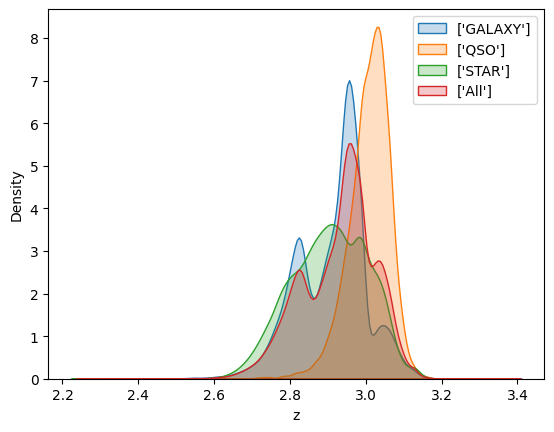

In [17]:
log_plot('z')

### Correlation Matrix

Text(0.5, 1.0, 'stellar correlation matrix')

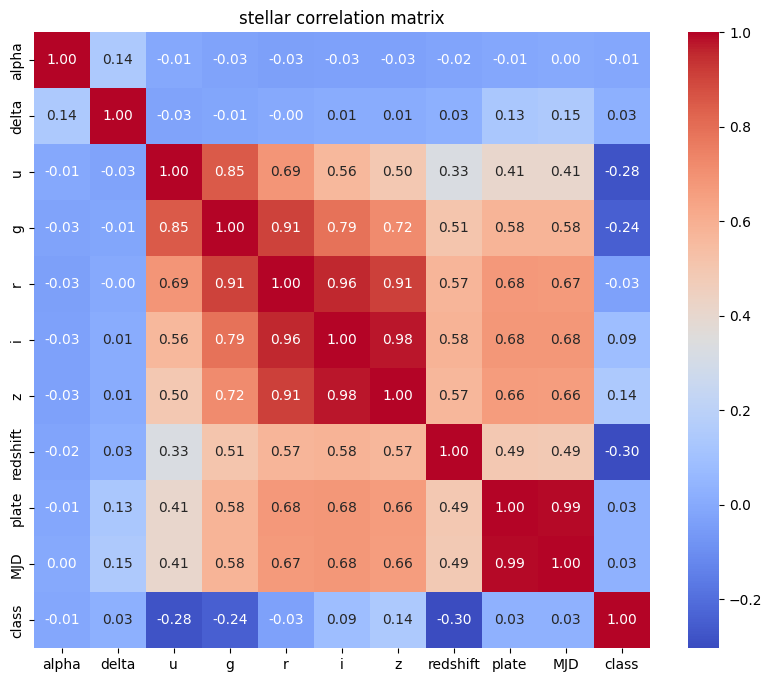

In [ ]:
corr_matt=Stars_df.corr(method="spearman")
plt.figure(figsize=(10,8))
sns.heatmap(corr_matt,annot=True,fmt="0.2f",cmap="coolwarm",square=True)
plt.title("stellar correlation matrix")

#decodation of class
Stars_df["class"] = le.inverse_transform(Stars_df["class"])

# Data Cleaning

### Outliners

In [ ]:
def rem_outliers():
    s1 = Stars_df.shape

    for i in Stars_df.select_dtypes(include = 'number').columns:
        qt1 = Stars_df[i].quantile(0.25)
        qt3 = Stars_df[i].quantile(0.75)
        iqr =  qt3 - qt1
        lower = qt1-(1.5*iqr)
        upper = qt3+(1.5*iqr)
        min_in = Stars_df[Stars_df[i]<lower].index
        max_in = Stars_df[Stars_df[i]>upper].index
        Stars_df.drop(min_in, inplace = True)
        Stars_df.drop(max_in, inplace = True)
    
    s2 = Stars_df.shape
    outliers = s1[0] - s2[0]
    return outliers

In [18]:
print('Number of outliners deleted: ', rem_outliers())

Number of outliners deleted:  9400


# Data modeling

## Modeling with RandomForest

### Creating and Training model

#### Features selection 

In [48]:
X = Stars_df.drop(columns='class', axis=1)
y = Stars_df['class']

#### Train/test split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Creating pipelines for modeling 

In [50]:
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()  

# Scale the numeric features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])


#Preprocesor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ]
)

#pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True)

#### Initialaizing RandomSearchCV

In [52]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'classifier__n_estimators': randint(50, 200),
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': randint(2, 10)
}



grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=5, 
    cv=cv,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['alpha',
                                                                                'delta',
                                                                                'u',
                                                                                'g',
                                                                                'r',
                                                                                'i',
                                                                                'z',
                                                                                'redshift',
                                                                                'plate',
                                                                                'MJD'])])),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'classifier__max_depth': [None, 10, 20,
                                                                  30],
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002497C8C1550>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002497380BB60>},
                   random_state=42, scoring='accuracy')

In [53]:
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters found:  {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 142}
Best cross-validation score: 0.98


### Classification reports

In [ ]:
test_score = grid_search.score(X_test, y_test )  
print("Test set score: {:.2f}".format(test_score))

Test set score: 0.98


In [55]:
y_pred = grid_search.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report


print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     11824
         QSO       0.94      0.86      0.90      1994
        STAR       0.99      1.00      1.00      4302

    accuracy                           0.98     18120
   macro avg       0.97      0.95      0.96     18120
weighted avg       0.98      0.98      0.98     18120



### Confusion matrix

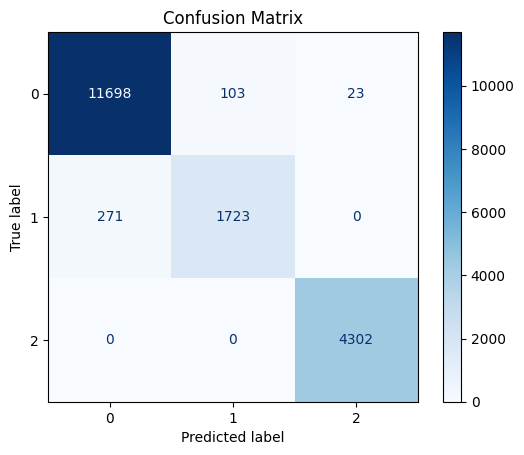

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

### Feature importance

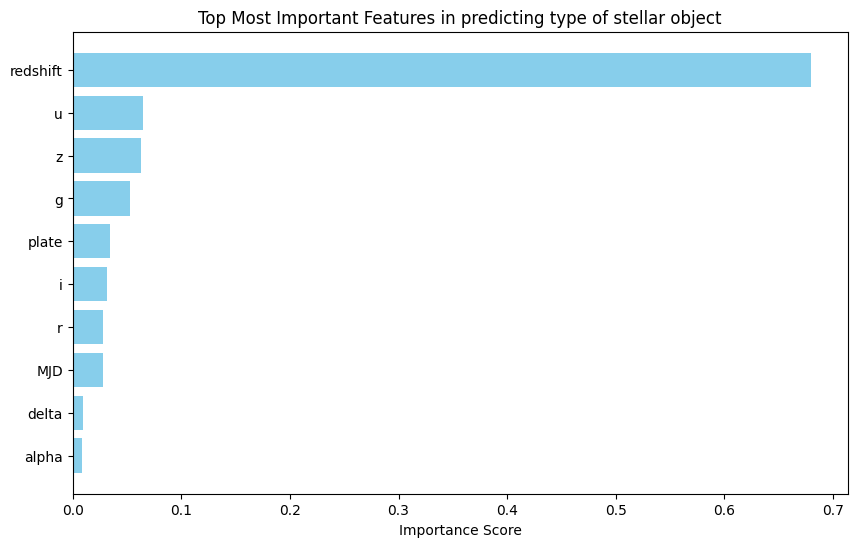

In [ ]:
feature_names = numeric_features 
feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)


top_features = importance_df

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title('Top Most Important Features in predicting type of stellar object')
plt.xlabel('Importance Score')
plt.show()

#### Redshift dominance

The previous plot shows that **redshift** heavily outweighs other features.  
This may suggest **overfitting** to that feature.  
We'll now train a new Random Forest model **excluding redshift** to verify its impact.

### Modeling wihout redshift

#### Creating and Training model

In [59]:
Stars_df_wr = Stars_df.copy()
Stars_df_wr = Stars_df.drop(columns='redshift', axis=1)

X_wr = Stars_df_wr.drop(columns='class', axis=1)
y_wr = Stars_df_wr['class']

X_train_wr, X_test_wr, y_train_wr, y_test_wr = train_test_split(X_wr, y_wr, test_size=0.2, stratify=y, random_state=42)

numeric_features = X_train_wr.select_dtypes(include=['number']).columns.tolist()  

# Scale the numeric features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

#Preprocesor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ]
)

#pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True)

grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=5, #later change to 10
    cv=cv,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

grid_search.fit(X_train_wr, y_train_wr)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['alpha',
                                                                                'delta',
                                                                                'u',
                                                                                'g',
                                                                                'r',
                                                                                'i',
                                                                                'z',
                                                                                'plate',
                                                                                'MJD'])])),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'classifier__max_depth': [None, 10, 20,
                                                                  30],
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002497C8C1550>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002497380BB60>},
                   random_state=42, scoring='accuracy')

#### Classification reports

In [60]:
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters found:  {'classifier__max_depth': None, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 152}
Best cross-validation score: 0.91


In [61]:
y_pred = grid_search.predict(X_test_wr)
print("\nClassification Report:")
print(classification_report(y_test_wr, y_pred))


Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.93      0.96      0.95     11824
         QSO       0.83      0.74      0.78      1994
        STAR       0.88      0.85      0.86      4302

    accuracy                           0.91     18120
   macro avg       0.88      0.85      0.86     18120
weighted avg       0.91      0.91      0.91     18120



#### Confusion Matrix

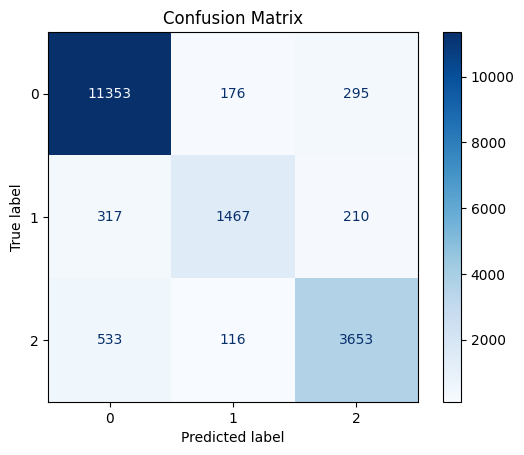

In [62]:
conf_matrix = confusion_matrix(y_test_wr, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

#### Feature importance

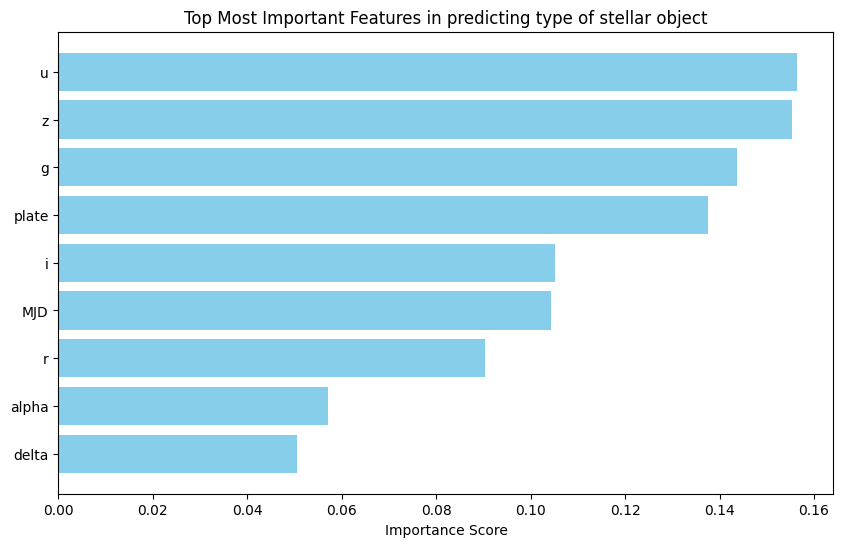

In [ ]:
feature_names = numeric_features 
feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)

top_features = importance_df

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title('Top Most Important Features in predicting type of stellar object')
plt.xlabel('Importance Score')
plt.show()

##### We see that after removing the **redshift** feature, the importance scores are more evenly distributed across the remaining features.

## Modeling with SVC

### Creating and Training model

#### Parameters distrubution for gridsearch

In [ ]:
param_dist = {
    'classifier__C': uniform(0.01, 10),
    'classifier__max_iter': [1000, 2000, 5000],
    'classifier__dual': [True],  
    'classifier__loss': ['hinge'],  
}

#### Creating pipeline with svm

In [ ]:
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()  

# Scale the numeric features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

#Preprocesor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ]
)

#pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearSVC(random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True)

grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=5,
    cv=cv,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)


grid_search.fit(X_train, y_train)

c:\Users\Gabri\Documents\GitHub\Stellar-Classification\.venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['alpha',
                                                                                'delta',
                                                                                'u',
                                                                                'g',
                                                                                'r',
                                                                                'i',
                                                                                'z',
                                                                                'redshift',
                                                                                'plate',
                                                                                'MJD'])])),
                                             ('classifier',
                                              LinearSVC(random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000249721E6E40>,
                                        'classifier__dual': [True],
                                        'classifier__loss': ['hinge'],
                                        'classifier__max_iter': [1000, 2000,
                                                                 5000]},
                   random_state=42, scoring='accuracy')

### Classification reports

In [66]:
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters found:  {'classifier__C': np.float64(5.9785015794648695), 'classifier__dual': True, 'classifier__loss': 'hinge', 'classifier__max_iter': 2000}
Best cross-validation score: 0.91


In [67]:
y_pred = grid_search.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.90      0.96      0.93     11824
         QSO       0.85      0.82      0.84      1994
        STAR       0.96      0.80      0.87      4302

    accuracy                           0.91     18120
   macro avg       0.90      0.86      0.88     18120
weighted avg       0.91      0.91      0.91     18120



### Confusion Matrix

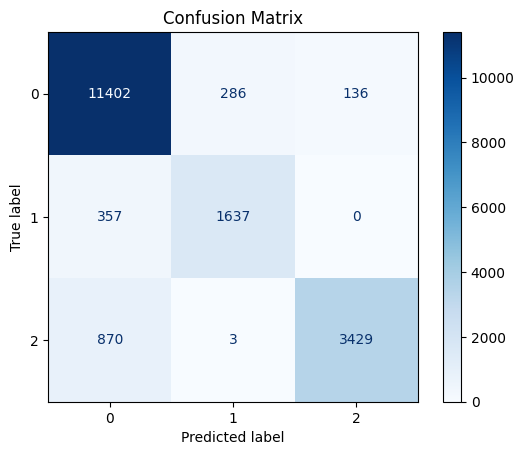

In [68]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

### Feature importance

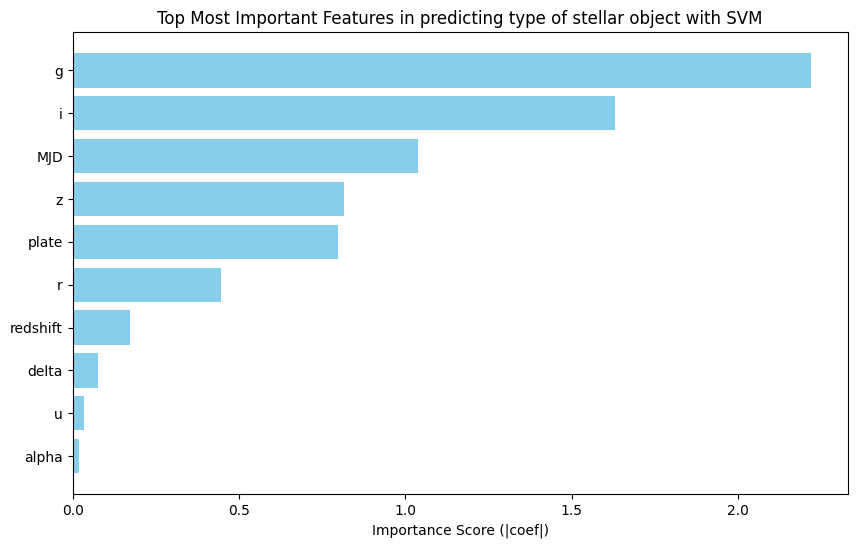

In [ ]:
clf = grid_search.best_estimator_['classifier']

coefs = clf.coef_[0]  # shape: (n_features,)
feature_importances = np.abs(coefs)  

feature_names = numeric_features  # Lista nazw cech


importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top Most Important Features in predicting type of stellar object with SVM')
plt.xlabel('Importance Score (|coef|)')
plt.show()